# Conformal Inference Foundations for Synthetic Control

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A1 | Notebook 1 of 2**

This notebook introduces conformal prediction as a framework for 
hypothesis testing in synthetic control settings, where traditional
asymptotic inference fails.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

---

## 1. Intuition {#intuition}

### The Inference Problem in Synthetic Control

**Standard SCM setup**:
- One treated unit (e.g., California)
- Multiple control units (other states)
- Treatment effect = Gap between treated and synthetic counterfactual

**Problem**: How do we know the gap is "real" vs noise?

**Why standard inference fails**:
1. **N=1**: Only one treated unit → no sampling distribution
2. **No repeated experiments**: Can't estimate variance from replication
3. **Constructed control**: Synthetic unit is estimated, not observed

> **Key insight**: We need inference that doesn't rely on asymptotic 
> approximations or large-N assumptions.

### Conformal Prediction to the Rescue

**Core idea**: Instead of assuming distributions, use permutation logic.

**Intuition**:
1. If treatment had no effect, California would look like any control state
2. Randomly permute "treated" label across all units
3. If California's gap is extreme compared to placebo gaps → reject null

This is **Fisher's exact test** adapted to synthetic control!

```
★ Insight ─────────────────────────────────────────────────────
Conformal inference requires NO assumptions about:
- Error distributions (normality)
- Sample size (asymptotics)
- Independence structure

Only assumption: Exchangeability of units under null hypothesis.
──────────────────────────────────────────────────────────────
```

---

## 2. Formal Treatment {#formal}

### 2.1 Setup and Notation

**Panel data structure**:
- $J+1$ units: $j = 1, ..., J+1$ (unit 1 is treated)
- $T$ time periods: $t = 1, ..., T$
- Pre-treatment: $t = 1, ..., T_0$
- Post-treatment: $t = T_0+1, ..., T$

**Outcome model**:
$$Y_{jt} = \alpha_t + \theta_{jt} D_{jt} + u_{jt}$$

where:
- $\alpha_t$ = common time effect
- $D_{jt}$ = treatment indicator (1 for treated unit post-treatment)
- $\theta_{jt}$ = treatment effect (time-varying)
- $u_{jt}$ = unit-specific residual

### 2.2 Null Hypothesis

**Sharp null** (no effect at any post-treatment period):

$$H_0: \theta_{1t} = \theta^0_t \quad \forall t > T_0$$

Common choice: $\theta^0_t = 0$ (no treatment effect).

Under the null, we can construct **adjusted outcomes**:

$$\tilde{Y}_{1t} = Y_{1t} - \theta^0_t \cdot D_{1t}$$

### 2.3 Test Statistic

**Residuals under null**:

For each unit $j$, compute synthetic control residuals:

$$\hat{u}_{jt} = Y_{jt} - \hat{Y}^{SC}_{jt}$$

where $\hat{Y}^{SC}_{jt}$ is the synthetic control prediction.

**General test statistic**:

$$S(\hat{u}) = \left( \sum_{t > T_0} |\hat{u}_t|^q \right)^{1/q}$$

Common choices:
- $q = 1$: Sum of absolute residuals (robust to outliers)
- $q = 2$: Root sum of squared residuals (RMSPE)
- $q = \infty$: Maximum absolute residual

### 2.4 Permutation Distribution

**Key exchangeability assumption**:

Under $H_0$, the residuals $(u_{1t}, ..., u_{J+1,t})$ are exchangeable.

**Block permutation procedure**:

1. For each unit $j = 1, ..., J+1$:
   - Pretend unit $j$ is treated
   - Fit synthetic control using remaining $J$ units
   - Compute post-treatment residuals $\hat{u}^{(j)}$
   - Compute test statistic $S_j = S(\hat{u}^{(j)})$

2. P-value:
$$p = \frac{1}{J+1} \sum_{j=1}^{J+1} \mathbf{1}\{S_j \geq S_1\}$$

**Interpretation**: Fraction of placebo effects as large as California's.

### 2.5 Pre-Treatment Fit Quality Filter

**Problem**: Some placebos fit poorly → uninformative comparisons.

**Solution**: Filter by pre-treatment RMSPE ratio:

$$\text{Ratio}_j = \frac{\text{Post-RMSPE}_j}{\text{Pre-RMSPE}_j}$$

Exclude units with $\text{Pre-RMSPE}_j > \tau$ (e.g., $\tau = 2 \times \text{Pre-RMSPE}_1$).

```
★ Key Result ──────────────────────────────────────────────────
The conformal p-value is **exact** under exchangeability:

$$P(\text{p-value} \leq \alpha | H_0) \leq \alpha$$

No asymptotics, no distributional assumptions required.
──────────────────────────────────────────────────────────────
```

---

## 3. Numeric Demonstration {#numeric}

### Simulated Panel Data

In [2]:
def generate_panel_data(n_units=10, n_pre=20, n_post=10, true_effect=5.0, seed=42):
    """
    Generate panel data for synthetic control.
    
    Unit 0 is treated starting at period n_pre.
    
    Parameters
    ----------
    n_units : int
        Number of units (including treated)
    n_pre : int
        Number of pre-treatment periods
    n_post : int
        Number of post-treatment periods
    true_effect : float
        True treatment effect on unit 0
    seed : int
        Random seed
        
    Returns
    -------
    pd.DataFrame
        Panel data with unit, time, outcome, treated columns
    """
    np.random.seed(seed)
    
    n_periods = n_pre + n_post
    
    # Unit fixed effects
    unit_effects = np.random.randn(n_units) * 2
    
    # Time trend (common to all)
    time_trend = np.cumsum(np.random.randn(n_periods) * 0.3)
    
    # Generate outcomes
    rows = []
    for j in range(n_units):
        for t in range(n_periods):
            # Base outcome
            y = 50 + unit_effects[j] + time_trend[t] + np.random.randn() * 1.5
            
            # Treatment effect for unit 0 in post-period
            if j == 0 and t >= n_pre:
                y += true_effect
            
            rows.append({
                'unit': j,
                'time': t,
                'outcome': y,
                'treated': 1 if (j == 0 and t >= n_pre) else 0,
                'post': 1 if t >= n_pre else 0
            })
    
    return pd.DataFrame(rows)

# Generate data
panel = generate_panel_data(n_units=10, n_pre=20, n_post=10, true_effect=5.0)
print(f"Panel shape: {panel.shape}")
print(f"\nUnits: {panel['unit'].nunique()}, Periods: {panel['time'].nunique()}")
print(f"Treated observations: {panel['treated'].sum()}")

Panel shape: (300, 5)

Units: 10, Periods: 30
Treated observations: 10


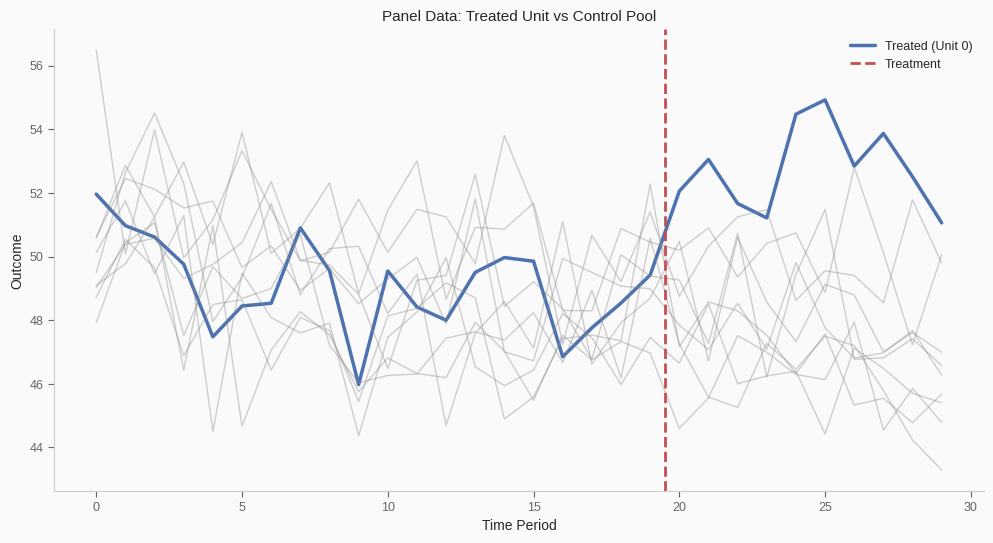

In [3]:
# Visualize panel
fig, ax = plt.subplots(figsize=(12, 6))

for unit in panel['unit'].unique():
    unit_data = panel[panel['unit'] == unit]
    if unit == 0:
        ax.plot(unit_data['time'], unit_data['outcome'], 
                color=COLORS['blue'], linewidth=2.5, label='Treated (Unit 0)')
    else:
        ax.plot(unit_data['time'], unit_data['outcome'], 
                color=COLORS['gray'], alpha=0.4, linewidth=1)

# Treatment onset
ax.axvline(x=19.5, color=COLORS['red'], linestyle='--', linewidth=2, label='Treatment')

ax.set_xlabel('Time Period')
ax.set_ylabel('Outcome')
ax.set_title('Panel Data: Treated Unit vs Control Pool')
ax.legend()
apply_tufte_style(ax)
plt.show()

### Simple Synthetic Control Estimator

In [4]:
from scipy.optimize import minimize

def fit_synthetic_control(panel, treated_unit, pre_periods):
    """
    Fit synthetic control weights to minimize pre-treatment MSE.
    
    Parameters
    ----------
    panel : pd.DataFrame
        Panel data with unit, time, outcome columns
    treated_unit : int
        Unit ID to treat as "treated"
    pre_periods : list
        Time periods to use for fitting
        
    Returns
    -------
    dict
        weights: array of unit weights
        control_units: list of control unit IDs
        pre_rmse: pre-treatment RMSE
    """
    # Separate treated and control
    control_units = [u for u in panel['unit'].unique() if u != treated_unit]
    n_controls = len(control_units)
    
    # Get pre-treatment outcomes
    pre_data = panel[panel['time'].isin(pre_periods)]
    
    # Treated unit pre-treatment outcomes
    y_treated = pre_data[pre_data['unit'] == treated_unit].sort_values('time')['outcome'].values
    
    # Control units pre-treatment outcomes (matrix: periods x units)
    X_control = np.column_stack([
        pre_data[pre_data['unit'] == u].sort_values('time')['outcome'].values
        for u in control_units
    ])
    
    # Objective: minimize ||y_treated - X_control @ w||^2
    def objective(w):
        return np.sum((y_treated - X_control @ w)**2)
    
    # Constraints: w >= 0, sum(w) = 1
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    ]
    bounds = [(0, 1) for _ in range(n_controls)]
    
    # Initial guess: uniform weights
    w0 = np.ones(n_controls) / n_controls
    
    # Optimize
    result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Compute pre-treatment RMSE
    fitted = X_control @ result.x
    pre_rmse = np.sqrt(np.mean((y_treated - fitted)**2))
    
    return {
        'weights': result.x,
        'control_units': control_units,
        'pre_rmse': pre_rmse
    }

# Fit SC for treated unit
pre_periods = list(range(20))
sc_result = fit_synthetic_control(panel, treated_unit=0, pre_periods=pre_periods)

print("Synthetic Control Weights:")
for u, w in zip(sc_result['control_units'], sc_result['weights']):
    if w > 0.01:
        print(f"  Unit {u}: {w:.3f}")
print(f"\nPre-treatment RMSE: {sc_result['pre_rmse']:.3f}")

Synthetic Control Weights:
  Unit 1: 0.220
  Unit 3: 0.269
  Unit 4: 0.114
  Unit 6: 0.151
  Unit 8: 0.247

Pre-treatment RMSE: 0.962


In [5]:
def compute_synthetic_outcome(panel, weights, control_units, periods):
    """
    Compute synthetic control outcome as weighted average.
    
    Parameters
    ----------
    panel : pd.DataFrame
        Panel data
    weights : array
        SC weights
    control_units : list
        Control unit IDs
    periods : list
        Time periods
        
    Returns
    -------
    array
        Synthetic outcome for each period
    """
    period_data = panel[panel['time'].isin(periods)]
    
    synthetic = np.zeros(len(periods))
    for i, t in enumerate(sorted(periods)):
        t_data = period_data[period_data['time'] == t]
        for u, w in zip(control_units, weights):
            y_u = t_data[t_data['unit'] == u]['outcome'].values[0]
            synthetic[i] += w * y_u
    
    return synthetic

# Compute synthetic outcome for all periods
all_periods = list(range(30))
synthetic_outcome = compute_synthetic_outcome(
    panel, sc_result['weights'], sc_result['control_units'], all_periods
)

# Get actual treated outcome
treated_outcome = panel[panel['unit'] == 0].sort_values('time')['outcome'].values

# Compute gap (treatment effect estimate)
gap = treated_outcome - synthetic_outcome

print("Post-treatment gaps (treatment effect estimates):")
for t in range(20, 30):
    print(f"  Period {t}: {gap[t]:.2f}")
print(f"\nMean post-treatment gap: {np.mean(gap[20:]):.2f} (True effect: 5.0)")

Post-treatment gaps (treatment effect estimates):
  Period 20: 4.57
  Period 21: 4.69
  Period 22: 3.68
  Period 23: 2.76
  Period 24: 6.59
  Period 25: 7.76
  Period 26: 3.64
  Period 27: 6.65
  Period 28: 5.61
  Period 29: 4.13

Mean post-treatment gap: 5.01 (True effect: 5.0)


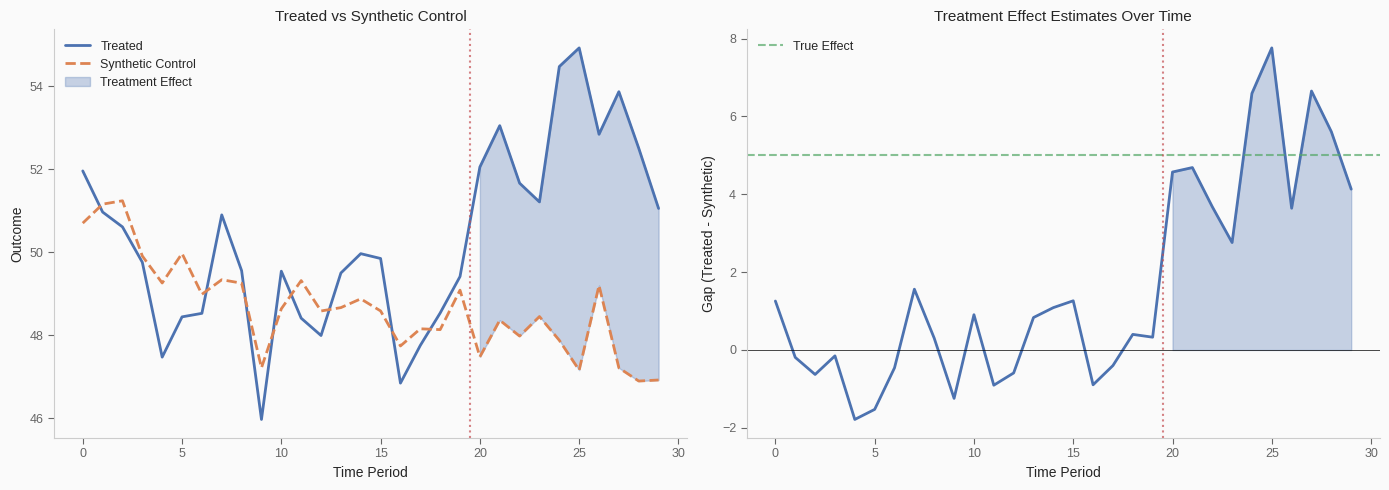

In [6]:
# Visualize treated vs synthetic
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Outcomes
ax = axes[0]
ax.plot(all_periods, treated_outcome, color=COLORS['blue'], linewidth=2, label='Treated')
ax.plot(all_periods, synthetic_outcome, color=COLORS['orange'], linewidth=2, 
        linestyle='--', label='Synthetic Control')
ax.axvline(x=19.5, color=COLORS['red'], linestyle=':', alpha=0.7)
ax.fill_between(range(20, 30), treated_outcome[20:], synthetic_outcome[20:], 
                alpha=0.3, color=COLORS['blue'], label='Treatment Effect')
ax.set_xlabel('Time Period')
ax.set_ylabel('Outcome')
ax.set_title('Treated vs Synthetic Control')
ax.legend()
apply_tufte_style(ax)

# Panel 2: Gap
ax = axes[1]
ax.plot(all_periods, gap, color=COLORS['blue'], linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=5, color=COLORS['green'], linestyle='--', alpha=0.7, label='True Effect')
ax.axvline(x=19.5, color=COLORS['red'], linestyle=':', alpha=0.7)
ax.fill_between(range(20, 30), gap[20:], alpha=0.3, color=COLORS['blue'])
ax.set_xlabel('Time Period')
ax.set_ylabel('Gap (Treated - Synthetic)')
ax.set_title('Treatment Effect Estimates Over Time')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

---

## 4. Implementation {#implementation}

### Conformal Inference via Block Permutation

In [7]:
def compute_test_statistic(residuals, q=2):
    """
    Compute test statistic from residuals.
    
    S(u) = (sum |u_t|^q)^(1/q)
    
    Parameters
    ----------
    residuals : array
        Post-treatment residuals
    q : float
        Order of Lq norm (1, 2, or np.inf)
        
    Returns
    -------
    float
        Test statistic value
    """
    if q == np.inf:
        return np.max(np.abs(residuals))
    else:
        return np.sum(np.abs(residuals)**q)**(1/q)


def conformal_scm_pvalue(panel, treated_unit, pre_periods, post_periods, 
                          q=2, pre_rmse_threshold=None):
    """
    Compute conformal p-value for synthetic control.
    
    Parameters
    ----------
    panel : pd.DataFrame
        Panel data
    treated_unit : int
        Actually treated unit
    pre_periods : list
        Pre-treatment periods
    post_periods : list
        Post-treatment periods
    q : float
        Order of test statistic
    pre_rmse_threshold : float or None
        Maximum pre-treatment RMSE for inclusion
        
    Returns
    -------
    dict
        p_value: conformal p-value
        test_stats: test statistics for all units
        pre_rmse: pre-treatment RMSE for all units
        included_units: units included after filtering
    """
    all_units = panel['unit'].unique()
    all_periods = list(pre_periods) + list(post_periods)
    
    results = []
    
    for placebo_unit in all_units:
        # Fit SC treating this unit as "treated"
        sc_fit = fit_synthetic_control(panel, placebo_unit, pre_periods)
        
        # Compute synthetic outcome
        synthetic = compute_synthetic_outcome(
            panel, sc_fit['weights'], sc_fit['control_units'], all_periods
        )
        
        # Get actual outcome for this unit
        actual = panel[panel['unit'] == placebo_unit].sort_values('time')['outcome'].values
        
        # Compute post-treatment residuals
        n_pre = len(pre_periods)
        post_residuals = actual[n_pre:] - synthetic[n_pre:]
        
        # Compute test statistic
        test_stat = compute_test_statistic(post_residuals, q)
        
        results.append({
            'unit': placebo_unit,
            'test_stat': test_stat,
            'pre_rmse': sc_fit['pre_rmse'],
            'is_treated': placebo_unit == treated_unit
        })
    
    results_df = pd.DataFrame(results)
    
    # Apply pre-RMSE filter if specified
    if pre_rmse_threshold is not None:
        included = results_df[results_df['pre_rmse'] <= pre_rmse_threshold].copy()
    else:
        included = results_df.copy()
    
    # Compute p-value
    treated_stat = included[included['is_treated']]['test_stat'].values[0]
    p_value = np.mean(included['test_stat'] >= treated_stat)
    
    return {
        'p_value': p_value,
        'test_stats': results_df,
        'included_units': included['unit'].tolist(),
        'treated_stat': treated_stat
    }

# Compute conformal p-value
pre_periods = list(range(20))
post_periods = list(range(20, 30))

conf_result = conformal_scm_pvalue(
    panel, treated_unit=0, pre_periods=pre_periods, post_periods=post_periods, q=2
)

print(f"Conformal p-value: {conf_result['p_value']:.3f}")
print(f"Treated unit test statistic: {conf_result['treated_stat']:.2f}")
print(f"\nUnits included: {len(conf_result['included_units'])}")

Conformal p-value: 0.100
Treated unit test statistic: 16.54

Units included: 10


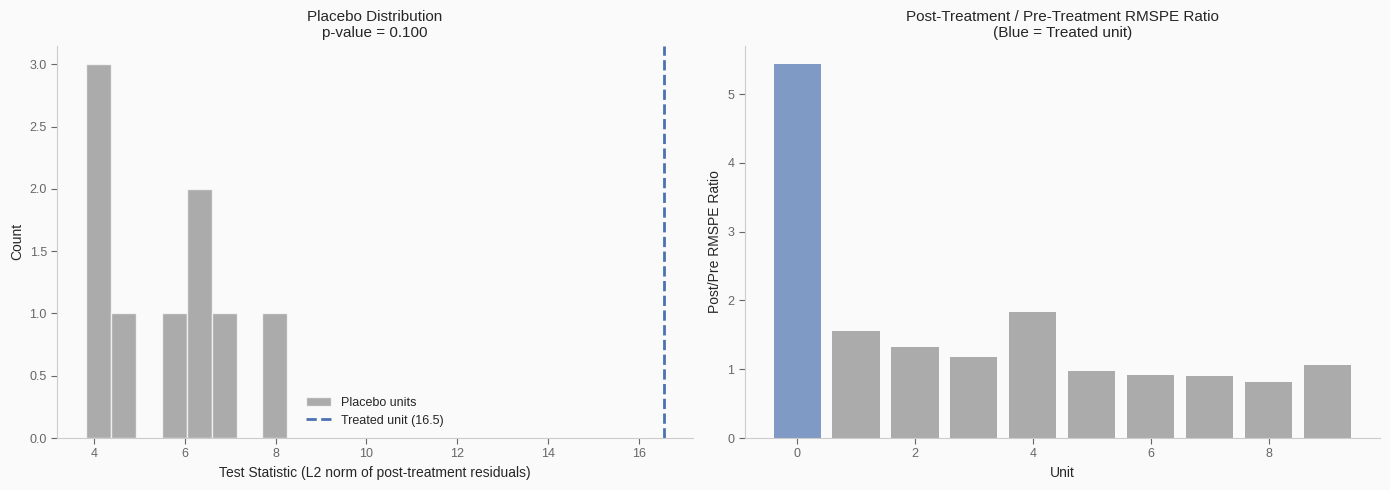

In [8]:
# Visualize placebo distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

test_stats = conf_result['test_stats']

# Panel 1: Test statistic distribution
ax = axes[0]
placebo_stats = test_stats[~test_stats['is_treated']]['test_stat'].values
treated_stat = conf_result['treated_stat']

ax.hist(placebo_stats, bins=8, alpha=0.7, color=COLORS['gray'], 
        edgecolor='white', label='Placebo units')
ax.axvline(x=treated_stat, color=COLORS['blue'], linewidth=2, 
           linestyle='--', label=f'Treated unit ({treated_stat:.1f})')
ax.set_xlabel('Test Statistic (L2 norm of post-treatment residuals)')
ax.set_ylabel('Count')
ax.set_title(f'Placebo Distribution\np-value = {conf_result["p_value"]:.3f}')
ax.legend()
apply_tufte_style(ax)

# Panel 2: Ratio of post/pre RMSPE
ax = axes[1]
# Compute post-treatment RMSE for ratio
test_stats_copy = test_stats.copy()
test_stats_copy['post_rmse'] = test_stats_copy['test_stat'] / np.sqrt(len(post_periods))
test_stats_copy['ratio'] = test_stats_copy['post_rmse'] / test_stats_copy['pre_rmse']

colors = [COLORS['blue'] if x else COLORS['gray'] for x in test_stats_copy['is_treated']]
ax.bar(range(len(test_stats_copy)), test_stats_copy['ratio'].values, color=colors, alpha=0.7)
ax.set_xlabel('Unit')
ax.set_ylabel('Post/Pre RMSPE Ratio')
ax.set_title('Post-Treatment / Pre-Treatment RMSPE Ratio\n(Blue = Treated unit)')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

### Effect of Pre-RMSE Filtering

In [9]:
# Compare with and without pre-RMSE filtering
treated_pre_rmse = test_stats[test_stats['is_treated']]['pre_rmse'].values[0]
threshold = 2 * treated_pre_rmse  # Exclude units with 2x worse pre-fit

conf_result_filtered = conformal_scm_pvalue(
    panel, treated_unit=0, pre_periods=pre_periods, post_periods=post_periods, 
    q=2, pre_rmse_threshold=threshold
)

print("Comparison of filtering approaches:")
print(f"\nNo filter:")
print(f"  Units: {len(conf_result['included_units'])}")
print(f"  p-value: {conf_result['p_value']:.3f}")

print(f"\nWith pre-RMSE filter (threshold = 2x treated):")
print(f"  Units: {len(conf_result_filtered['included_units'])}")
print(f"  p-value: {conf_result_filtered['p_value']:.3f}")

# Show excluded units
excluded = set(conf_result['included_units']) - set(conf_result_filtered['included_units'])
if excluded:
    print(f"\nExcluded units: {excluded}")
    for u in excluded:
        pre_rmse = test_stats[test_stats['unit'] == u]['pre_rmse'].values[0]
        print(f"  Unit {u}: pre-RMSE = {pre_rmse:.2f} > {threshold:.2f}")

Comparison of filtering approaches:

No filter:
  Units: 10
  p-value: 0.100

With pre-RMSE filter (threshold = 2x treated):
  Units: 9
  p-value: 0.111

Excluded units: {6}
  Unit 6: pre-RMSE = 2.25 > 1.92


### Sensitivity to Test Statistic Choice

In [10]:
# Compare different q values
q_values = [1, 2, np.inf]
q_names = ['L1 (sum of abs)', 'L2 (RMSPE)', 'L∞ (max abs)']

print("Sensitivity to test statistic choice:")
print("-" * 50)

for q, name in zip(q_values, q_names):
    result = conformal_scm_pvalue(
        panel, treated_unit=0, pre_periods=pre_periods, post_periods=post_periods, q=q
    )
    print(f"{name:20s}: p-value = {result['p_value']:.3f}")

Sensitivity to test statistic choice:
--------------------------------------------------


L1 (sum of abs)     : p-value = 0.100


L2 (RMSPE)          : p-value = 0.100


L∞ (max abs)        : p-value = 0.100


```
★ Key Takeaway ────────────────────────────────────────────────
Conformal inference for SCM:

1. **No distributional assumptions** - exact test under exchangeability
2. **Pre-treatment fit matters** - poor fits = uninformative placebos
3. **Test statistic choice** - usually L2, but L1 more robust to outliers
4. **Conservative with few donors** - J+1 permutations limits resolution

Rule of thumb: Need J+1 ≥ 1/α for p-value ≤ α
(e.g., at least 20 units for p ≤ 0.05)
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: Why can't we use standard errors for synthetic control?

<details>
<summary>Solution</summary>

**Three fundamental problems**:

1. **N=1 treated unit**
   - Standard inference requires repeated sampling
   - With one treated unit, no variance estimate possible

2. **Constructed counterfactual**
   - Synthetic control is estimated, not observed
   - Weights are optimized → uncertainty in weights not captured by OLS SE

3. **No asymptotic justification**
   - Central limit theorem requires many observations
   - Adding more control units doesn't help (still 1 treated)
   - Adding more time periods → serial correlation issues

**Solution**: Use permutation-based inference that:
- Makes no distributional assumptions
- Requires only exchangeability under null
- Gives exact p-values for finite samples

</details>

### Q2: What is the exchangeability assumption in conformal SCM inference?

<details>
<summary>Solution</summary>

**Exchangeability under H₀**:

If there's no treatment effect, the residuals $(u_{1t}, u_{2t}, ..., u_{J+1,t})$ 
are exchangeable across units.

**What this means**:
- Under the null, California's post-treatment residuals have the same 
  distribution as any control state's residuals
- Permuting the "treated" label across units gives valid placebo tests

**When it might fail**:
1. **Heterogeneous shocks**: If California systematically differs from controls 
   in ways not captured by synthetic control
2. **Spillovers**: If treatment affects control units (SUTVA violation)
3. **Anticipation effects**: If units react before formal treatment

**Key insight**: Exchangeability is about the *error structure*, not the outcomes.
The synthetic control construction handles level differences.

</details>

### Q3: How does pre-treatment fit quality affect inference?

<details>
<summary>Solution</summary>

**Problem with poor pre-treatment fit**:

If a placebo unit has poor pre-treatment fit (high pre-RMSPE), then:
1. Post-treatment residuals will be large *even without treatment*
2. Test statistic inflated by pre-existing poor fit
3. Comparison with treated unit is misleading

**Example**:
- Treated unit: Pre-RMSPE = 1.0, Post-RMSPE = 5.0 → Ratio = 5.0
- Placebo unit: Pre-RMSPE = 10.0, Post-RMSPE = 12.0 → Ratio = 1.2

The placebo has larger absolute residuals but smaller *relative* change.

**Solutions**:

1. **Filter by pre-RMSPE**: Exclude units with pre-RMSPE > k × treated's pre-RMSPE
   - Facure uses k = 2
   - Abadie et al. suggest RMSPE < 80

2. **Use ratio statistic**: Post-RMSPE / Pre-RMSPE instead of just Post-RMSPE

3. **Visual inspection**: Plot all placebo gaps to identify outliers

</details>

### Q4: What's the minimum number of control units needed?

<details>
<summary>Solution</summary>

**Resolution of p-value**:

With $J+1$ total units (1 treated + J controls), possible p-values are:
$$p \in \left\{\frac{1}{J+1}, \frac{2}{J+1}, ..., 1\right\}$$

**Minimum for significance**:

| α level | Min units (J+1) |
|---------|----------------|
| 0.10 | 10 |
| 0.05 | 20 |
| 0.01 | 100 |

**Practical implications**:

1. **Prop 99 example**: 39 states → minimum p = 1/39 ≈ 0.026
   - Can achieve p < 0.05 but not p < 0.01

2. **After filtering**: If pre-RMSPE filter removes units, resolution worsens
   - 39 units → filter to 20 → minimum p = 1/20 = 0.05

3. **Reporting**: Always report exact p-value and number of comparison units

</details>

### Q5: How does conformal inference relate to Fisher's exact test?

<details>
<summary>Solution</summary>

**Fisher's exact test** (1935):
- Test sharp null hypothesis of no individual treatment effects
- Compute test statistic under all possible randomization assignments
- P-value = fraction of assignments with statistic ≥ observed

**Conformal SCM inference**:
- Same logic, but "assignment" = which unit is treated
- Compute statistic treating each unit as placebo treated
- P-value = fraction of placebos with statistic ≥ observed

**Key difference**:

| Fisher's Test | Conformal SCM |
|--------------|---------------|
| Many units, random assignment | Few units, one treated |
| Permute treatment across units | Permute "placebo treated" label |
| Tests effect on population | Tests effect on *this* treated unit |
| Design-based | Model-based (SC construction) |

**Connection**:
Both give **exact** inference under the null without distributional assumptions.
The conformal approach extends Fisher's logic to observational panel data.

</details>

---

## 6. References {#references}

[^1]: Abadie, A., Diamond, A., & Hainmueller, J. (2010). Synthetic Control Methods 
      for Comparative Case Studies. *Journal of the American Statistical Association*.

[^2]: Abadie, A. (2021). Using Synthetic Controls: Feasibility, Data Requirements, 
      and Methodological Aspects. *Journal of Economic Literature*.

[^3]: Chernozhukov, V., Wuthrich, K., & Zhu, Y. (2021). An Exact and Robust Conformal 
      Inference Method for Counterfactual and Synthetic Controls. *JASA*.

[^4]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix: 
      Conformal Inference for Synthetic Control.